# Another 1D GP Example

We generate realizations of a simple one dimensional Gaussian Process with zero mean and Matérn covariance. Then we use the LaplaceInterpolation procedure to produce the interpolation.

## Generate some data with Matèrn covariance 

We use the GaussianProcesses.jl package to first make up a GP and then generate realizations from it. The parameters given to this package are on a log scale. 

In [1]:
using GaussianProcesses, LaplaceInterpolation, Random, LinearAlgebra
using Plots, Statistics, StatsPlots, BenchmarkTools
Random.seed!(20140430);

In [2]:
function get_gp(ν, ll, lσ)
    kern = Matern(ν, ll, lσ)                   
    # We will use no observation noise here for the purposes of generating data
    return GP(x, y, MeanZero(), kern)
end

function gprealiz(x, y, ν, ll, lσ, n2, nrealiz = 1)
    kern = Matern(ν, ll, lσ)                   
    # We will use no observation noise here for the purposes of generating data
    gp = GP(x, y, MeanZero(), kern)
    # Generate realizations of the data. It is given as μ + σLV, where L is the Cholesky factor of K
    # and V is drawn from an iid N(0,1) distribution
    μ, Σ = predict_f(gp, collect(1.0:n2), full_cov = true)
    L = cholesky(Σ)
    realiz = zeros(n2, nrealiz)
    for i in 1:nrealiz
        realiz[:, i] = μ + L.L * randn(n2)
    end
    return realiz
end

function sqdist(r, interp, discard)
    return sum(abs2, r[discard] .- interp[discard])
end

sqdist (generic function with 1 method)

## A single realization on a toy example

In [6]:
# Training data
n = 10
n2 = 20
v = Float64.(randperm(n2))
x = sort(v[1:n])
y = sin.(2π * x * 0.1) + 0.05*randn(n)

keep = Int64.(x)
discard = sort(Int64.(v[(n+1):n2]))

# The Matern parameters are set on a log scale
ν = 1.5
ll = 0.5
lσ = 0.0 #0.05

nrealiz = 1

# Aspect ratio
h = 1.0

# Dimension, Matern parameter, etc
d = 1
# m = nu + d/2
m = 2 
# epsilon = sqrt(2*nu)/length_scale
epsilon = sqrt(3)/exp(ll)

# Generate a single realization of the gp
gp = get_gp(ν, ll, lσ)
realiz = gprealiz(x, y, ν, ll, lσ, n2, nrealiz);

## Interpolate using Matérn and Laplace interpolation

Here we assume the Matérn parameters are known and interpolate using them. We need to convert between the log-parameters given to the GP function above and the notation we've used, m, and $\epsilon$. 

In [7]:
y_lap = mapslices(z -> matern_1d_grid(z, discard, 1, 1.0, h), realiz, dims = 1)
y_mat = mapslices(z -> matern_1d_grid(z, discard, m, epsilon, h), realiz, dims = 1)
μ     = predict_y(GP(x, realiz[keep], MeanZero(), Matern(ν, ll, lσ)), Float64.(discard))[1];

Plotting the realization atop the simple 1D GP.

Squared distance between Laplace interpolation and the truth: 4.526374603545465
Squared distance between Matern interpolation and the truth: 5.161498648853637
Squared distance between GP Matern interpolation and the truth: 10.372493953781568


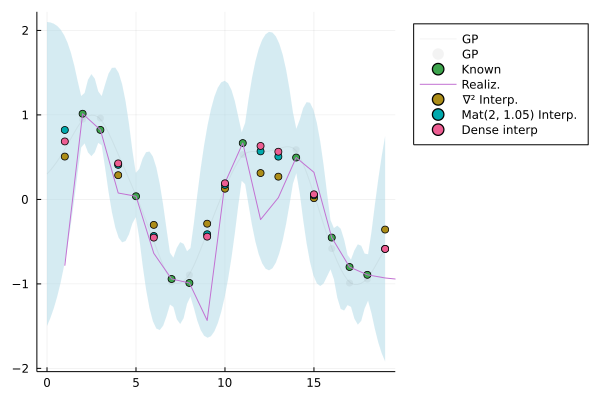

In [8]:
println("Squared distance between Laplace interpolation and the truth: $(sqdist(realiz, y_lap, discard))")
println("Squared distance between Matern interpolation and the truth: $(sqdist(realiz, y_mat, discard))")
println("Squared distance between GP Matern interpolation and the truth: $(sqdist(realiz, μ, 1:10))")

plot(gp, label = "GP", alpha = 0.05, legend = :outertopright, xlims = [0, maximum(x) + 1])
scatter!(keep, realiz[keep], label="Known")
plot!(realiz, label = "Realiz.")
scatter!(discard, y_lap[discard], label = "∇² Interp.")
scatter!(discard, y_mat[discard], label = "Mat($m, $(round(epsilon, sigdigits = 3))) Interp.")
scatter!(discard, μ, label = "Dense interp")

# Statistical Averages

Clearly, we cannot say anything about the general behavior of such an approximation with just one realization.

## Generate more data

Need to generate more data and vary both size of the data and roughness. We will benchmark the code. 

In [29]:
# Training data
n = 100
n2 = 1000
v = Float64.(randperm(n2))
x = sort(v[1:n])
y = sin.(2π * x * 0.01) + 0.05*randn(n)

keep = Int64.(x)
discard = sort(Int64.(v[(n+1):n2]))

# The Matern parameters are set on a log scale
ν = 1.5
#ll = 0.5
#lσ = 0.0 #0.05
nrealiz = 1000
m = 2

realiz = gprealiz(x, y, ν, ll, lσ, n2, nrealiz);

## Benchmark the interpolation

### Laplace interpolation

In [30]:
@benchmark matern_1d_grid(realiz[:,1], discard, 1, 1.0, h)

BechmarkTools.Trial: 5288 samples with 1 evaluations.
 Range (min … max):  669.782 μs …   8.781 ms  ┊ GC (min … max): 0.00% … 39.85%
 Time  (median):     849.001 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   935.313 μs ± 633.814 μs  ┊ GC (mean ± σ):  6.11% ±  7.82%

   ▂█                                                            
  ▃██▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▁▁▂▁▁▁▂▂▂▂▂▂▂ ▂
  670 μs           Histogram: frequency by time         5.49 ms <

 Memory estimate: 1.56 MiB, allocs estimate: 145.

### Matérn interpolation

In [31]:
@benchmark matern_1d_grid(realiz[:,2], discard, m, epsilon, h)

BechmarkTools.Trial: 5705 samples with 1 evaluations.
 Range (min … max):  632.263 μs …   8.257 ms  ┊ GC (min … max): 0.00% … 46.24%
 Time  (median):     786.510 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   867.631 μs ± 674.698 μs  ┊ GC (mean ± σ):  6.91% ±  7.82%

   █▄                                                            
  ▇██▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▂
  632 μs           Histogram: frequency by time         5.76 ms <

 Memory estimate: 1.56 MiB, allocs estimate: 145.

### Dense (GP) Interpolation

In [32]:
@benchmark predict_y(gp, Float64.(discard))

BechmarkTools.Trial: 4572 samples with 1 evaluations.
 Range (min … max):  807.749 μs …  11.140 ms  ┊ GC (min … max): 0.00% … 90.06%
 Time  (median):     994.377 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.088 ms ± 856.756 μs  ┊ GC (mean ± σ):  7.62% ±  8.73%

   ▇ ▂  ▃▃▄█▅▅▃                                                  
  ▅█▇█▇█████████▇▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂ ▃
  808 μs           Histogram: frequency by time          230 ms <

 Memory estimate: 900.77 KiB, allocs estimate: 8109.

## Accuracy of the approximation

In [33]:
y_lap = mapslices(z -> matern_1d_grid(z, discard, 1, 1.0, h), realiz, dims = 1)
y_mat = mapslices(z -> matern_1d_grid(z, discard, m, epsilon, h), realiz, dims = 1);
μ = mapslices(z -> predict_y(GP(x, z[keep, 1], MeanZero(), Matern(ν, ll, lσ)), Float64.(discard))[1], realiz, dims = 1)

900×1000 Array{Float64,2}:
  0.0046932   0.00503549   0.003416     …   0.00475171   0.00343697
  0.0086076   0.00923538   0.00626514       0.00871492   0.0063036
  0.0157868   0.0169382    0.0114906        0.0159837    0.0115612
  0.028954    0.0310656    0.0210745        0.0293149    0.0212038
  0.0531032   0.0569762    0.0386518        0.0537653    0.0388891
  0.0973944   0.104498     0.0708896    …   0.0986086    0.0713248
  0.178627    0.191655     0.130016         0.180854     0.130814
  0.327612    0.351505     0.238456         0.331696     0.23992
  0.406556    0.555743     0.572541         0.485287     0.462408
  0.222126    0.384819     0.524387         0.317958     0.377596
  0.162045    0.238003     0.322769     …   0.210224     0.238234
  0.163428    0.181461     0.243576         0.182227     0.189233
  0.226798    0.193747     0.256771         0.223347     0.212007
  ⋮                                     ⋱               
 -0.0162532  -0.0213392   -0.0207372       -0.020170

Looking at one of the realizations and the interpolation we get, we see that the squared distance between the interpolation and the truth is smaller for the Matérn.

Mean squared distance between the Laplacian interpolation and the truth: 836.4077890822044.
Mean squared distance between the Matern interpolation and the truth: 837.4921428376094.
Mean squared distance between the GP interpolation and the truth: 8.68308908161124.


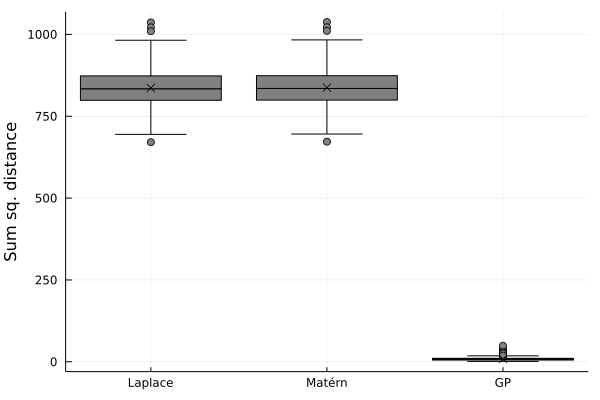

In [34]:
# Compute the squared distance for all the interpolations
lap_dist = map(i -> sqdist(realiz[:, i], y_lap[:, i], discard), 1:nrealiz)
mat_dist = map(i -> sqdist(realiz[:, i], y_mat[:, i], discard), 1:nrealiz)
gp_dist = map(i -> sqdist(realiz[discard, i], μ[:, i], 1:10), 1:nrealiz)

ml = mean(lap_dist)
mm = mean(mat_dist)
mgp = mean(gp_dist)

println("Mean squared distance between the Laplacian interpolation and the truth: $(mean(lap_dist)).")
println("Mean squared distance between the Matern interpolation and the truth: $(mean(mat_dist)).")
println("Mean squared distance between the GP interpolation and the truth: $(mean(gp_dist)).")

p1 = boxplot([lap_dist, mat_dist, gp_dist], label = ["Laplace" "Matern" "GP"], ylabel = "Sum sq. distance",
        xtick = ([1.0, 2.0, 3.0], ["Laplace", "Matérn", "GP"]), legend = false, c = :gray)
scatter!(p1, 1:3, [ml, mm, mgp], markershape = :x , c = :black, label = "Mean")